<a href="https://colab.research.google.com/github/suyeonb/AI_lab_baesuyeon/blob/main/week9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, time, copy, json, random
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


torch: 2.8.0+cu126
cuda available: True


device(type='cuda')

In [ ]:
import os, zipfile, shutil, random, pathlib

ZIP_PATH = "/content/sample_computer_vision.zip"     # 왼쪽에 보이는 파일 이름
EXTRACT_DIR = "/content/sample_computer_vision_raw"  # 1차 해제 위치
DATA_ROOT = "/content/sample_computer_vision"        # 최종 학습용 루트(여기에 train/val 구조 만들 것)

# 1) 압축 해제
assert os.path.exists(ZIP_PATH), f"ZIP이 없어요: {ZIP_PATH}"
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

def first_real_dir(path):
    """압축 안에 최상위 폴더가 한 개만 있을 때 그 폴더로 들어가도록 보정."""
    entries = [d for d in os.listdir(path) if not d.startswith(".")]
    if len(entries) == 1 and os.path.isdir(os.path.join(path, entries[0])):
        return os.path.join(path, entries[0])
    return path

unzipped_root = first_real_dir(EXTRACT_DIR)
print("unzipped_root:", unzipped_root)

# 2) 최종 학습용 루트 폴더 초기화
if os.path.exists(DATA_ROOT):
    shutil.rmtree(DATA_ROOT)
os.makedirs(DATA_ROOT, exist_ok=True)

# 3) unzip된 내용 전체를 DATA_ROOT로 이동
for name in os.listdir(unzipped_root):
    src = os.path.join(unzipped_root, name)
    dst = os.path.join(DATA_ROOT, name)
    if os.path.isdir(src):
        shutil.copytree(src, dst)
    else:
        shutil.copy2(src, dst)

print("DATA_ROOT ready:", DATA_ROOT)
print("Top-level:", os.listdir(DATA_ROOT))

unzipped_root: /content/sample_computer_vision_raw/sample_computer_vision
DATA_ROOT ready: /content/sample_computer_vision
Top-level: ['val', 'train']


In [ ]:
import os, random, shutil

def ensure_train_val_structure(data_root, seed=42, split_ratio=0.8):
    entries = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and not d.startswith(".")]
    has_split = any(n in entries for n in ["train","val","valid","validation"])
    if has_split:
        print("train/val 구조가 이미 있어요. 그대로 진행합니다.")
        return

    # 클래스 폴더를 찾아 train/val로 이동(8:2)
    class_dirs = [d for d in entries if d.lower() not in ("train","val","valid","validation")]
    assert class_dirs, "클래스 폴더(예: cats, dogs)가 DATA_ROOT 바로 아래에 있어야 합니다."

    train_dir = os.path.join(data_root, "train");  os.makedirs(train_dir, exist_ok=True)
    val_dir   = os.path.join(data_root, "val");    os.makedirs(val_dir, exist_ok=True)

    random.seed(seed)
    for cls in class_dirs:
        src = os.path.join(data_root, cls)
        if not os.path.isdir(src):
            continue
        files = [f for f in os.listdir(src) if not f.startswith(".")]
        random.shuffle(files)
        cut = int(len(files) * split_ratio)
        train_files, val_files = files[:cut], files[cut:]

        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir,   cls), exist_ok=True)

        for f in train_files:
            shutil.move(os.path.join(src, f), os.path.join(train_dir, cls, f))
        for f in val_files:
            shutil.move(os.path.join(src, f), os.path.join(val_dir,   cls, f))

        # 빈 원본 폴더 정리
        try:
            os.rmdir(src)
        except OSError:
            pass

    print("분할 완료!")
    print("train classes:", os.listdir(os.path.join(data_root, "train")))
    print("val   classes:", os.listdir(os.path.join(data_root, "val")))

ensure_train_val_structure(DATA_ROOT)

train/val 구조가 이미 있어요. 그대로 진행합니다.


In [ ]:
# 폴더 구조 빠르게 확인
for root, dirs, files in os.walk(DATA_ROOT):
    level = root.replace(DATA_ROOT, "").count(os.sep)
    indent = "  " * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = "  " * (level + 1)
    for f in files[:3]:  # 각 폴더에서 최대 3개만 미리보기
        print(f"{subindent}{f}")


sample_computer_vision/
  val/
    cats/
      cat.4079.jpg
      cat.4044.jpg
      cat.4055.jpg
    dogs/
      dog.4014.jpg
      dog.4100.jpg
      dog.4051.jpg
  train/
    cats/
      cat.135.jpg
      cat.362.jpg
      cat.91.jpg
    dogs/
      dog.352.jpg
      dog.477.jpg
      dog.268.jpg


In [ ]:
import os, numpy as np, matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DATA_ROOT = "/content/sample_computer_vision"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(DATA_ROOT,'train'), data_transforms['train']),
    'val'  : datasets.ImageFolder(os.path.join(DATA_ROOT,'val'),   data_transforms['val'])
}
class_names = image_datasets['train'].classes
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True),
    'val'  : DataLoader(image_datasets['val'],   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True),
}
dataset_sizes = {k: len(v) for k,v in image_datasets.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("classes:", class_names, "| sizes:", dataset_sizes, "| device:", device)


classes: ['cats', 'dogs'] | sizes: {'train': 1002, 'val': 200} | device: cuda


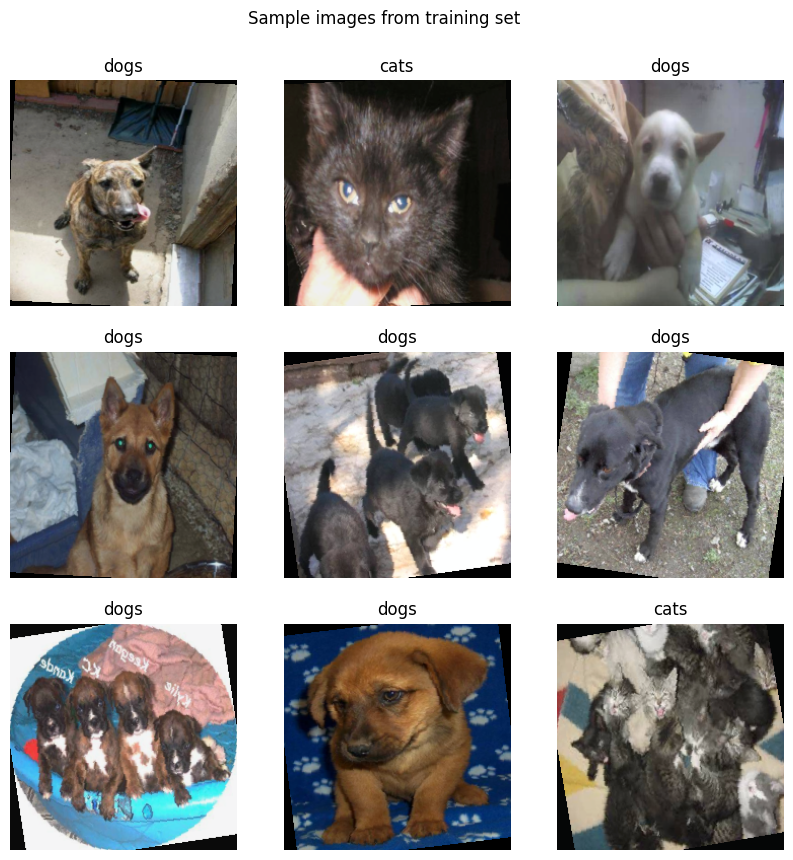

In [ ]:
# 1
def imshow(t, title=None):
    img = t.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406]); std = np.array([0.229,0.224,0.225])
    img = np.clip(std*img + mean, 0, 1)
    plt.imshow(img); plt.axis("off")
    if title: plt.title(title)

inputs, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(10,10))
for i in range(min(9, inputs.size(0))):
    plt.subplot(3,3,i+1)
    imshow(inputs[i].cpu(), title=class_names[labels[i]])
plt.suptitle("Sample images from training set", y=0.95)
plt.show()

In [ ]:
import copy, json, torch.nn as nn, torch.optim as optim
from torch.optim import lr_scheduler
from collections import defaultdict
from torchvision import models

FREEZE_BACKBONE = True
LR = 1e-3
EPOCHS = 10

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
if FREEZE_BACKBONE:
    for p in model.parameters():
        p.requires_grad = False
in_features = model.fc.in_features
model.fc = nn.Sequential(nn.Dropout(0.2), nn.Linear(in_features, len(class_names)))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

SAVE_DIR = os.path.join(DATA_ROOT, "_runs"); os.makedirs(SAVE_DIR, exist_ok=True)
best_path = os.path.join(SAVE_DIR, "best_resnet18.pth")
log_path  = os.path.join(SAVE_DIR, "train_log.json")

history = defaultdict(list)
best_acc, best_wts = 0.0, copy.deepcopy(model.state_dict())

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}\n" + "-"*30)
    epoch_log = {"epoch": epoch, "train": {}, "val": {}}

    for phase in ["train","val"]:
        model.train() if phase=="train" else model.eval()
        running_loss, running_corrects = 0.0, 0

        for x, y in dataloaders[phase]:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.set_grad_enabled(phase=="train"):
                out = model(x)
                loss = criterion(out, y)
                if phase=="train":
                    loss.backward(); optimizer.step()
            running_loss += loss.item()*x.size(0)
            running_corrects += (out.argmax(1)==y).sum().item()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc  = running_corrects / dataset_sizes[phase]
        history[f"{phase}_loss"].append(epoch_loss)
        history[f"{phase}_acc"].append(epoch_acc)
        epoch_log[phase] = {"loss": epoch_loss, "acc": epoch_acc}
        print(f"{phase:>5} | loss: {epoch_loss:.4f} acc: {epoch_acc*100:6.2f}%")

        if phase=="val" and epoch_acc>best_acc:
            best_acc, best_wts = epoch_acc, copy.deepcopy(model.state_dict())
            torch.save(best_wts, best_path)
            print(f"  -> Best updated! {best_acc*100:.2f}% saved to {best_path}")

    scheduler.step()
    with open(log_path, "a") as f:
        f.write(json.dumps(epoch_log, ensure_ascii=False)+"\n")

print("\nTraining done. Best val acc: %.2f%%" % (best_acc*100))
model.load_state_dict(best_wts)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]



Epoch 1/10
------------------------------
train | loss: 0.3892 acc:  81.84%
  val | loss: 0.2312 acc:  93.50%
  -> Best updated! 93.50% saved to /content/sample_computer_vision/_runs/best_resnet18.pth

Epoch 2/10
------------------------------
train | loss: 0.2006 acc:  93.11%
  val | loss: 0.1478 acc:  98.00%
  -> Best updated! 98.00% saved to /content/sample_computer_vision/_runs/best_resnet18.pth

Epoch 3/10
------------------------------
train | loss: 0.1786 acc:  92.61%
  val | loss: 0.1309 acc:  98.00%

Epoch 4/10
------------------------------
train | loss: 0.1365 acc:  95.31%
  val | loss: 0.1277 acc:  98.00%

Epoch 5/10
------------------------------
train | loss: 0.1147 acc:  96.41%
  val | loss: 0.1200 acc:  98.00%

Epoch 6/10
------------------------------
train | loss: 0.1215 acc:  95.71%
  val | loss: 0.1194 acc:  98.50%
  -> Best updated! 98.50% saved to /content/sample_computer_vision/_runs/best_resnet18.pth

Epoch 7/10
------------------------------
train | loss: 0.11

<All keys matched successfully>

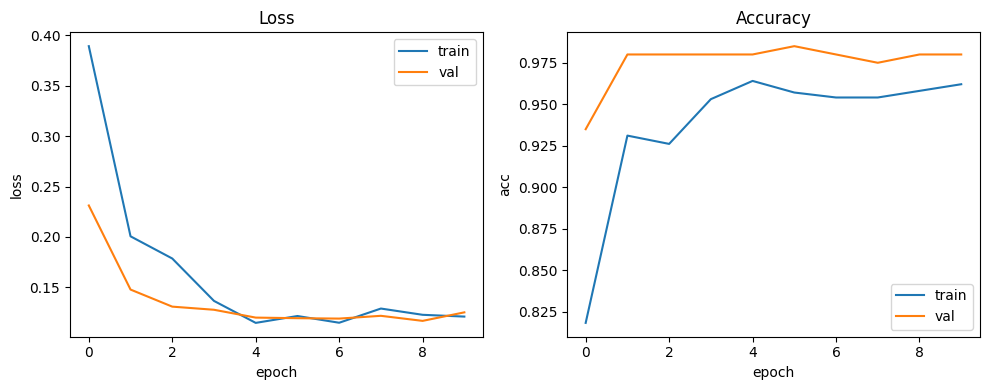

Classification Report
              precision    recall  f1-score   support

        cats     1.0000    0.9700    0.9848       100
        dogs     0.9709    1.0000    0.9852       100

    accuracy                         0.9850       200
   macro avg     0.9854    0.9850    0.9850       200
weighted avg     0.9854    0.9850    0.9850       200



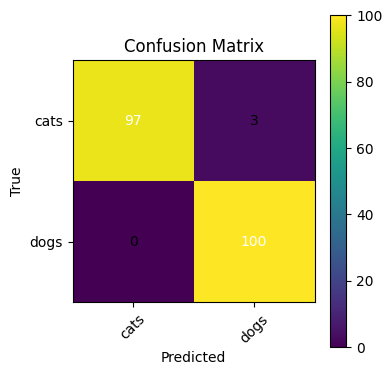

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, itertools, torch

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history['train_loss'], label="train"); plt.plot(history['val_loss'], label="val")
plt.title("Loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history['train_acc'],  label="train"); plt.plot(history['val_acc'],  label="val")
plt.title("Accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
plt.tight_layout(); plt.show()

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for x, y in dataloaders['val']:
        out = model(x.to(device))
        y_pred.extend(out.argmax(1).cpu().numpy().tolist())
        y_true.extend(y.numpy().tolist())

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(len(class_names))
plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
th = cm.max()/2
for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i,j]), ha="center", va="center", color="white" if cm[i,j]>th else "black")
plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()


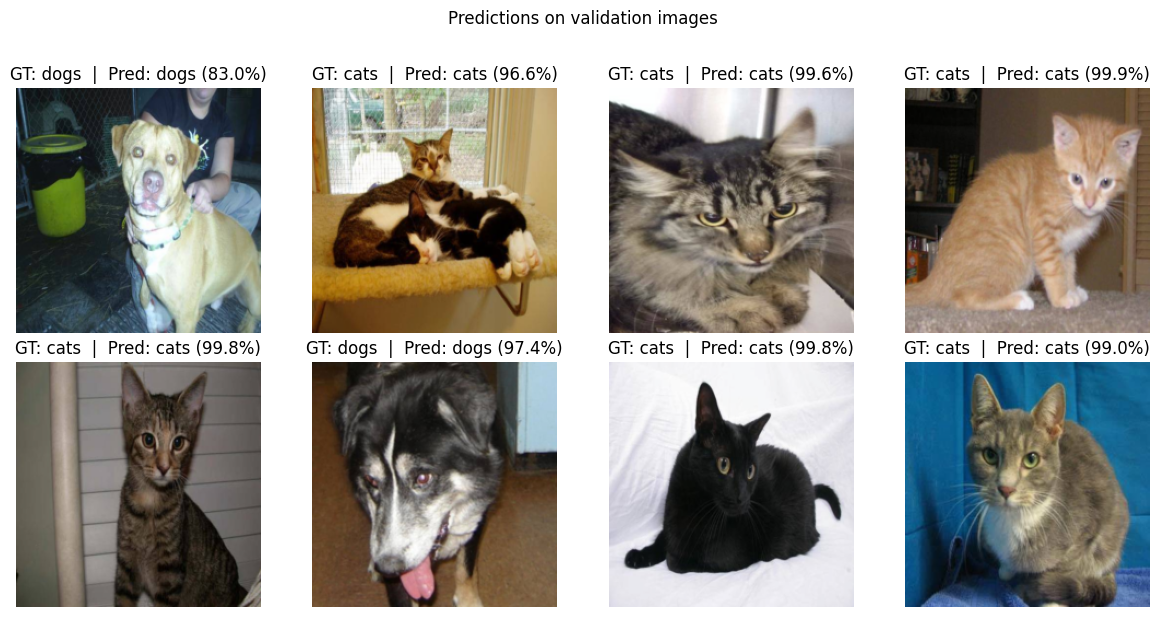

In [ ]:
def predict_images_grid(dset, count=8):
    model.eval()
    idxs = np.random.choice(len(dset), size=min(count, len(dset)), replace=False)
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(idxs, 1):
        img, label = dset[idx]
        with torch.no_grad():
            prob = torch.softmax(model(img.unsqueeze(0).to(device)), dim=1).squeeze(0).cpu().numpy()
        pred = prob.argmax()
        title = f"GT: {class_names[label]}  |  Pred: {class_names[pred]} ({prob[pred]*100:.1f}%)"
        plt.subplot(2, (count+1)//2, i);
        imshow(img, title=title)
    plt.suptitle("Predictions on validation images", y=1.02)
    plt.tight_layout(); plt.show()

predict_images_grid(image_datasets['val'], count=8)


In [ ]:
print("Best model:", os.path.join(DATA_ROOT, "_runs", "best_resnet18.pth"))
print("Train log :", os.path.join(DATA_ROOT, "_runs", "train_log.json"))


Best model: /content/sample_computer_vision/_runs/best_resnet18.pth
Train log : /content/sample_computer_vision/_runs/train_log.json
